##Aclaración
El siguiente código ha sido desarrollado por IAUAI y se encuentra con licencia de código abierto, así que siéntete libre de usarlo y modificarlo a tu gusto ✌

Comentarios adicionales:
*   Esta versión del código fue generada conforme se iba probando entrenando el bot y viendo qué no funcionaba. Por lo mismo, es probable que obtengas mejores resultados que los que obtuvimos nosotr@s (de ser el caso, nos gustaría que nos comentaras 👀)
*   Este código está pensando únicamente para ser corrido en Google Colab sin GPU habilitada (se puede usar la GPU, pero hay que evitar que no corra el código por demasiado tiempo para que no te desconecte y pierdas lo avanzado)
*   No está la opción de exportar el bot entrenado para jugar contra él y, lamentablemente, tampoco sería algo trivial de habilitar
*   Se recomienda entrenar por lo mínimo 2 veces con 100 episodios para ver resultados más o menos significativos
*   El código ha sido comentado en algunas partes para facilitar la compresión del mismo

##Descargado de datos

Aquí podrías descargar otros juegos que te interesen más, aunque probablemente es más cómodo recolectarlos manualmente.

In [1]:
###Recuperado de: https://stackoverflow.com/questions/51046454/how-can-we-use-selenium-webdriver-in-colab-research-google-com
from IPython.display import clear_output
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
clear_output()
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
### (En pocas palabras, esto simular chrome y nos permite hacer cosas sofisticadas en internet, como descargar archivos)

#Aquí se descarga el juego
import time
wd.get("https://archive.org/download/No-Intro-Collection_2016-01-03_Fixed/Sega%20-%20Mega%20Drive%20-%20Genesis.zip/Mortal%20Kombat%203%20%28USA%29.zip")
time.sleep(10) #Hay que darle tiempo para que se descargue
wd.quit()

#Y aquí se extrae de su archivo zip
!unzip "./Mortal Kombat 3 (USA).zip"
!rm "./Mortal Kombat 3 (USA).zip"
clear_output()

#Finalmente, esto te permite descargar distintos estados (personajes) que habilitamos para Mortal kombat 3
!git clone https://github.com/IA-UAI/Proyecto_3_-_Bot_Mortiferum
%cd ./Proyecto_3_-_Bot_Mortiferum
%mv Estados ../
%cd ../
!rm -rf ./Proyecto_3_-_Bot_Mortiferum
clear_output()

##Configuración inicial

In [2]:
#Instalación y cargado de librerías
!pip install gym-retro
import retro
import matplotlib.pyplot as plt
from IPython import display
import os
clear_output()

#Lista de juegos ya integrados en gym retro y que podrías usar (si tienes la respectiva ROM)
#Puede que encuentras alguno aquí: https://ia600201.us.archive.org/view_archive.php?archive=/7/items/No-Intro-Collection_2016-01-03_Fixed/Sega%20-%20Mega%20Drive%20-%20Genesis.zip
print(retro.data.list_games())

#Importación de juegos encontrados
roms = [os.path.join("./", rom) for rom in os.listdir("./") if (rom[-3:] == ".md")]
retro.data.merge(*roms, quiet=False)
dir_estados = "./Estados/" #(En caso de que tengas alguna configuración específica del juego con el que quieres trabajar)

['1942-Nes', '1943-Nes', '3NinjasKickBack-Genesis', '8Eyes-Nes', 'AaahhRealMonsters-Genesis', 'AbadoxTheDeadlyInnerWar-Nes', 'AcceleBrid-Snes', 'ActRaiser2-Snes', 'ActionPachio-Snes', 'AddamsFamily-GameBoy', 'AddamsFamily-Genesis', 'AddamsFamily-Nes', 'AddamsFamily-Sms', 'AddamsFamily-Snes', 'AddamsFamilyPugsleysScavengerHunt-Nes', 'AddamsFamilyPugsleysScavengerHunt-Snes', 'AdvancedBusterhawkGleylancer-Genesis', 'Adventure-Atari2600', 'AdventureIsland-GameBoy', 'AdventureIsland3-Nes', 'AdventureIslandII-Nes', 'AdventuresOfBatmanAndRobin-Genesis', 'AdventuresOfBayouBilly-Nes', 'AdventuresOfDinoRiki-Nes', 'AdventuresOfDrFranken-Snes', 'AdventuresOfKidKleets-Snes', 'AdventuresOfMightyMax-Genesis', 'AdventuresOfMightyMax-Snes', 'AdventuresOfRockyAndBullwinkleAndFriends-Genesis', 'AdventuresOfRockyAndBullwinkleAndFriends-Nes', 'AdventuresOfRockyAndBullwinkleAndFriends-Snes', 'AdventuresOfStarSaver-GameBoy', 'AdventuresOfYogiBear-Snes', 'AeroFighters-Snes', 'AeroStar-GameBoy', 'AeroTheAcroBa

##Modelamiento

In [3]:
#Inspirado por: https://github.com/adam-osusky/Deep-Q-Learning-Atari-Space-Invaders/blob/master/DQN_implementation.ipynb
from tensorflow import keras, one_hot, GradientTape, math, constant, convert_to_tensor, reduce_sum, reduce_mean
from pathlib import Path
from cv2 import COLOR_BGR2GRAY, cvtColor, resize, INTER_NEAREST
import numpy as np
from tensorflow.random import set_seed
from subprocess import Popen, PIPE
from PIL import Image, ImageOps, ImageDraw, ImageFont
from base64 import b64encode
from google.colab import files, output
import gzip

set_seed(13)

def preprocesarImagen(imagen):
  return resize(cvtColor(imagen, COLOR_BGR2GRAY), (80, 56), interpolation = INTER_NEAREST).reshape(56, 80, 1)/255

activacion = "relu"
dim_inicial = [56, 80, 1]
capa_entrada1 = keras.layers.Input(dim_inicial, name="Capa_entrada_1")
capa_entrada2 = keras.layers.Input(12, name="Capa_entrada_2")
capa_entrada3 = keras.layers.Input(12, name="Capa_entrada_3")
capa_conv1 = keras.layers.Conv2D(4, kernel_size = 3, strides = 1, padding="valid", activation=activacion, use_bias=False,
                                 name="Capa_convolucional_1",
                                 kernel_initializer='glorot_normal', kernel_regularizer=keras.regularizers.l2(1e-5))(capa_entrada1)
capa_dropout1 = keras.layers.Dropout(0.1, name="Capa_dropout_1")(capa_conv1)
capa_pooling1 = keras.layers.MaxPooling2D(2, name="Capa_pooling_1")(capa_dropout1)
capa_conv2 = keras.layers.Conv2D(16, kernel_size = 3, strides = 1, padding="valid", activation=activacion, use_bias=False,
                                 name="Capa_convolucional_2",
                                 kernel_initializer='glorot_normal', kernel_regularizer=keras.regularizers.l2(1e-5))(capa_pooling1)
capa_dropout2 = keras.layers.Dropout(0.1, name="Capa_dropout_2")(capa_conv2)
capa_pooling2 = keras.layers.MaxPooling2D(2, name="Capa_pooling_2")(capa_dropout2)
capa_conv3 = keras.layers.Conv2D(32, kernel_size = 3, strides = 1, padding="valid", activation=activacion, use_bias=False,
                                 name="Capa_convolucional_3",
                                 kernel_initializer='glorot_normal', kernel_regularizer=keras.regularizers.l2(1e-5))(capa_pooling2)
capa_dropout3 = keras.layers.Dropout(0.1, name="Capa_dropout_3")(capa_conv3)
capa_pooling3 = keras.layers.MaxPooling2D(2, name="Capa_pooling_3")(capa_dropout3)
capa_flatten = keras.layers.Flatten(name="Capa_aplanadora")(capa_pooling3)
capa_dense1 = keras.layers.Dense(256, activation=activacion, kernel_initializer='glorot_normal', use_bias=False,
                                 name="Capa_densa_1",
                                 kernel_regularizer=keras.regularizers.l2(1e-5))(capa_flatten)
capa_dropout4 = keras.layers.Dropout(0.1, name="Capa_dropout_4")(capa_dense1)
capa_dense2 = keras.layers.Dense(64, activation=activacion, kernel_initializer='glorot_normal', use_bias=False,
                                 name="Capa_densa_2",
                                 kernel_regularizer=keras.regularizers.l2(1e-5))(capa_dropout4)
capa_union = keras.layers.Concatenate(name="Capa_concatenadora")([capa_dense2, capa_entrada2, capa_entrada3])
capa_dropout5 = keras.layers.Dropout(0.1, name="Capa_dropout_5")(capa_union)
capa_dense3 = keras.layers.Dense(12, activation='sigmoid', kernel_initializer='glorot_normal', use_bias=False,
                                 name="Capa_densa_3",
                                 kernel_regularizer=keras.regularizers.l2(1e-5))(capa_dropout5)
modelo = keras.models.Model([capa_entrada1, capa_entrada2, capa_entrada3], capa_dense3, name="El_modelo")

#Esta función determina si se hace una jugada al azar o no (o sea, si se quiere experimentar/explorar o no)
def politicaEpsilon(obs, accion_pasada, accion_ante_pasada, epsilon=0):
  if (np.random.rand() < epsilon):
    return convert_to_tensor([one_hot(np.random.randint(12), 12)])
  else:
    return modelo((convert_to_tensor([obs]), convert_to_tensor(accion_pasada), convert_to_tensor(accion_ante_pasada)))

def calculoDeUnaJugada(env, obs, obs_anterior, accion_pasada, accion_ante_pasada, epsilon):
  accion = math.round(politicaEpsilon((obs+obs_anterior)/2, accion_pasada, accion_ante_pasada, epsilon)[0])
  nueva_obs, recompensa, fin, info = env.step(accion)
  return preprocesarImagen(nueva_obs), recompensa, fin, info, [accion]

optimizador = keras.optimizers.RMSprop(0.00005, 0.99, 0.0, 1e-6)

def calculoDeUnaJugadaPrueba(env, obs, obs_anterior, accion_pasada, accion_ante_pasada, epsilon): #Así las imágenes se conservan en la resolución original
  obs_procesada = preprocesarImagen(obs)
  accion = math.round(politicaEpsilon((obs_procesada+obs_anterior)/2, accion_pasada, accion_ante_pasada, epsilon)[0])
  nueva_obs, recompensa, fin, info = env.step(accion)
  return nueva_obs, obs_procesada, recompensa, fin, info, [accion], accion_pasada

clear_output()

In [4]:
#Cargado del modelo
modelo_base = 0 #Hay que actualizar esto según se vaya avanzando
if (modelo_base > 0):
  modelo.load_weights("modelo"+str(modelo_base)+".h5")

#Selección del estado
el_estado = 'MK_Kabal.state' #Si quieres usar un estado, pon su respectivo nombre (Ejemplo: 'MK_Kabal.state')
                             #Caso contrario, sólo dejalo así: ''

###Visualizaciones adicionales del modelo

In [5]:
modelo.summary()

Model: "El_modelo"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Capa_entrada_1 (InputLayer)    [(None, 56, 80, 1)]  0           []                               
                                                                                                  
 Capa_convolucional_1 (Conv2D)  (None, 54, 78, 4)    36          ['Capa_entrada_1[0][0]']         
                                                                                                  
 Capa_dropout_1 (Dropout)       (None, 54, 78, 4)    0           ['Capa_convolucional_1[0][0]']   
                                                                                                  
 Capa_pooling_1 (MaxPooling2D)  (None, 27, 39, 4)    0           ['Capa_dropout_1[0][0]']         
                                                                                          

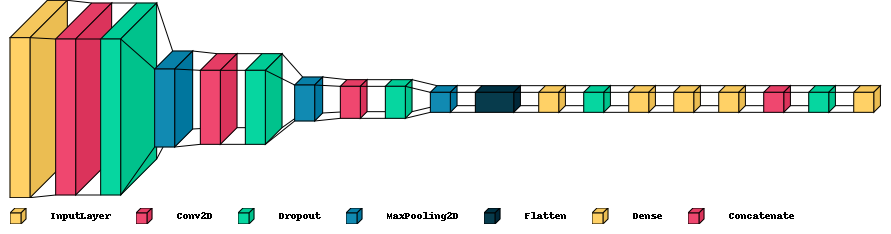

In [6]:
!pip install visualkeras
display.clear_output()
import visualkeras
visualkeras.layered_view(modelo, legend=True, spacing=25, scale_z=0.03, scale_xy=2)

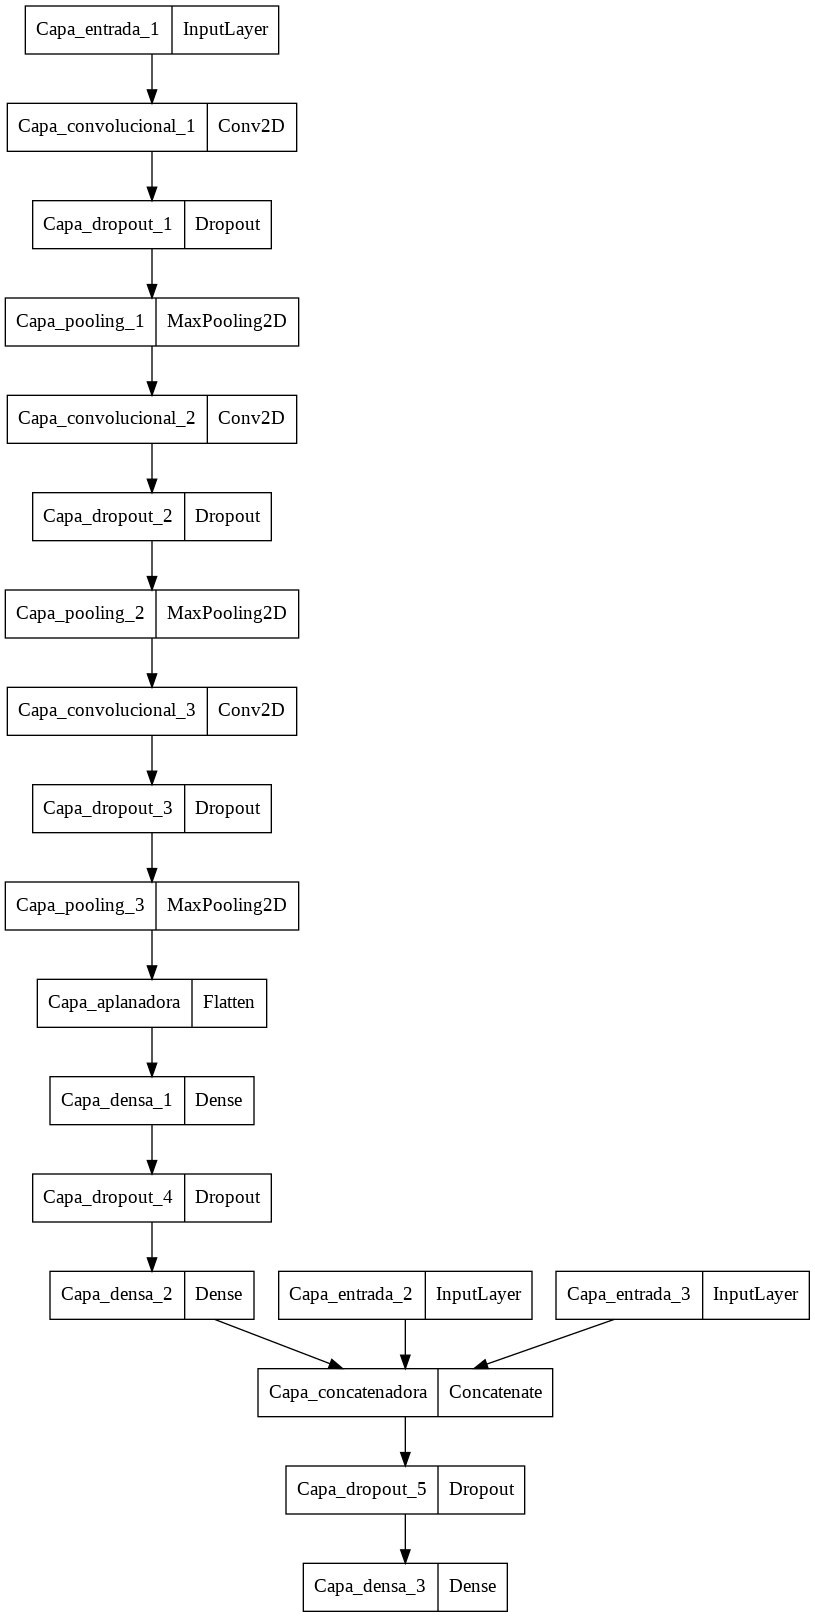

In [7]:
keras.utils.plot_model(modelo)

##Entrenamiento

In [8]:
def main(modelo_base):
  modelo_base = modelo_base
  hist_vida_enemigo = []
  hist_vida_personaje = []
  hist_episodios = []
  total_victorias = []
  mejor_victorias = 0
  mejor_extras = 0
  mejor_vida = 500

  env = retro.make(game='MortalKombat3-Genesis')
  if (el_estado != ''):
    f = gzip.open(dir_estados+el_estado,'rb')
    file_content = f.read()
    f.close()
  else:
    file_content = ''

  max_iteraciones = 20000
  ultimas_relevantes_i = 30 #Hay poderes especiales que pueden impactar con retraso
  ultimas_relevantes_f = 5 #Tarda por lo mínimo 5 frames el que un golpe normal impacte
  limite_gradiente = 500 #500 
  n_episodios = 50 #100
  estados = [] #(Debería aguantar como 13000 momentos relevantes. O sea, como 500 episodios)
  acciones = []
  acciones_pasadas = []
  acciones_antepasadas = []
  accion_0 = np.array([1]*12)
  matches_won = 0

  for episodio in range(n_episodios):
    obs = env.reset()
    if (el_estado != ''):
      env.em.set_state(file_content)
    if (modelo_base == 0): #En caso de que el bot no sepa nada
      epsilon = max(1 - episodio/n_episodios, 0.01)
    else:
      epsilon = 0.01*(len(estados) != limite_gradiente)
    accion = [accion_0]
    victorias = 0
    obs, rew, done, info = env.step(accion_0)
    obs = preprocesarImagen(obs)
    ultimos_estados = [obs]
    ultimas_acciones = [accion]

    #Juega hasta terminar la partida o que se alcancen las iteraciones máximas
    for iteracion in range(max_iteraciones):
      if (len(ultimos_estados) >= ultimas_relevantes_i+2): #+2 porque también aprende de las 2 últimas jugadas
        ultimos_estados = ultimos_estados[1:]
        ultimas_acciones = ultimas_acciones[1:]
      ultimos_estados += [obs]
      ultimas_acciones += [accion]
      vida_anterior_personaje = info['health']
      vida_anterior_enemigo = info['enemy_health']
      obs, recompensa, fin, info, accion = calculoDeUnaJugada(env, ultimos_estados[-1], ultimos_estados[-2],
                                                              ultimas_acciones[-1], ultimas_acciones[-2], epsilon)
      #Recibió daño por parte del enemigo
      if (vida_anterior_personaje > info['health']):
        #Registro de cómo recibió daño
        if (info['enemy_health'] > 0) or (vida_anterior_enemigo != info['enemy_health']):
          estados += [(np.stack(ultimos_estados[2:-ultimas_relevantes_f])+np.stack(ultimos_estados[1:-ultimas_relevantes_f-1]))/2]
          acciones += [np.stack([accion_0 - axion for axion in ultimas_acciones[2:-ultimas_relevantes_f]]).astype("float32")]
          acciones_pasadas += [np.stack(ultimas_acciones[1:-ultimas_relevantes_f-1])]
          acciones_antepasadas += [np.stack(ultimas_acciones[0:-ultimas_relevantes_f-2])]
        #La partida terminó y el personaje perdió
        if (info['health'] == 0) and (info['enemy_health'] > 0):
          hist_vida_personaje += [info['health']]
          hist_vida_enemigo += [info['enemy_health']]
          hist_episodios += [episodio]
      #Le hizo daño al enemigo
      if (vida_anterior_enemigo > info['enemy_health']):
        #Registro de cómo hacer daño
        if (info['health'] > 0) or (vida_anterior_personaje != info['health']):
          estados += [(np.stack(ultimos_estados[2:-ultimas_relevantes_f])+np.stack(ultimos_estados[1:-ultimas_relevantes_f-1]))/2]
          acciones += [np.stack(ultimas_acciones[2:-ultimas_relevantes_f])]
          acciones_pasadas += [np.stack(ultimas_acciones[1:-ultimas_relevantes_f-1])]
          acciones_antepasadas += [np.stack(ultimas_acciones[0:-ultimas_relevantes_f-2])]
        #La partida terminó y el personaje ganó
        if (info['enemy_health'] == 0):
          hist_vida_personaje += [info['health']]
          hist_vida_enemigo += [info['enemy_health']]
          hist_episodios += [episodio]
      display.clear_output()
      print(episodio, iteracion, info)
      #Esto es para que pase a enfocarse en derrotar a los nuevos personajes.
      if (info['wins'] > victorias):
        victorias = info['wins']
        if (len(estados) > limite_gradiente):
          estados = estados[:limite_gradiente]
          acciones = acciones[:limite_gradiente]
          acciones_pasadas = acciones_pasadas[:limite_gradiente]
          acciones_antepasadas = acciones_antepasadas[:limite_gradiente]
      if (fin):
        matches_won = info['matches_won']
        break
    total_victorias += [victorias]
    #Puede almacenar muchos, pero no puede con un gradiente tan grande.
    if (len(estados) > limite_gradiente):
      estados = estados[-limite_gradiente:]
      acciones = acciones[-limite_gradiente:]
      acciones_pasadas = acciones_pasadas[-limite_gradiente:]
      acciones_antepasadas = acciones_antepasadas[-limite_gradiente:]
    if (len(estados) != limite_gradiente): continue #Es mejor esperar a que acumule varias jugadas significativas
    elif (mejor_victorias < victorias) or ((mejor_victorias == victorias) and (mejor_extras < matches_won)) or \
        ((mejor_victorias == victorias) and (mejor_extras == matches_won) and (mejor_vida > hist_vida_enemigo[-1])):
      mejor_victorias = victorias
      mejor_extras = matches_won
      mejor_vida = hist_vida_enemigo[-1]
      modelo.save_weights("mejor_actual.h5")
    print(len(estados))
    #Aquí es donde ocurre el aprendizaje.
    # if (victorias > 2) and (len(estados) == limite_gradiente): break #Aquí podrías poner un límite de victorias que te gustaría
    #                                                                  #alcanzar, para que tu bot se detenga cuando lo logre
    with GradientTape() as tape:
      perdidas = math.squared_difference(modelo(((np.concatenate(estados),
                                                  np.concatenate(acciones_pasadas)[:,0,:],
                                                  np.concatenate(acciones_antepasadas)[:,0,:]))),
                                        convert_to_tensor(np.concatenate(acciones)[:,0,:]))
      perdida_final = reduce_mean(perdidas)
    grads = tape.gradient(perdida_final, modelo.trainable_variables)
    optimizador.apply_gradients(zip(grads, modelo.trainable_variables)) #(El optimizador parece limitar la RAM de alguna forma)
    del grads
    del perdidas
    del perdida_final
  env.close()
  modelo_base += 1
  del estados
  del acciones
  del acciones_pasadas
  del acciones_antepasadas
  del ultimos_estados
  del ultimas_acciones
  if (modelo_base > 0): modelo.load_weights("mejor_actual.h5")
  return modelo_base, hist_vida_enemigo, hist_vida_personaje, hist_episodios, total_victorias, mejor_victorias, mejor_extras, mejor_vida

if (__name__ == "__main__"):
  modelo_base, hist_vida_enemigo, hist_vida_personaje, hist_episodios, total_victorias, mejor_victorias, mejor_extras, mejor_vida = main(modelo_base)

49 2402 {'matches_won': 0, 'wins': 0, 'enemy_matches_won': 2, 'enemy_health': 134, 'health': 0}
500


In [9]:
#Guardado y descarga del modelo
indice_modelo = modelo_base
while (Path("modelo"+str(indice_modelo)+".h5").is_file()):
  indice_modelo += 1
modelo.save_weights("modelo"+str(indice_modelo)+".h5")
files.download("modelo"+str(indice_modelo)+".h5")
print("modelo"+str(indice_modelo)+".h5 generado con éxito")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

modelo1.h5 generado con éxito


###Gráfico de resultado de cada batalla

FRECUENCIA DE MÁXIMOS ENEMIGOS QUE DERROTÓ ||| {0: 49, 1: 1}
MEJOR RESULTADO ||| Enemigos derrotados: 0 | Victorias contra últim@: 1 | Vida de últim@: 121


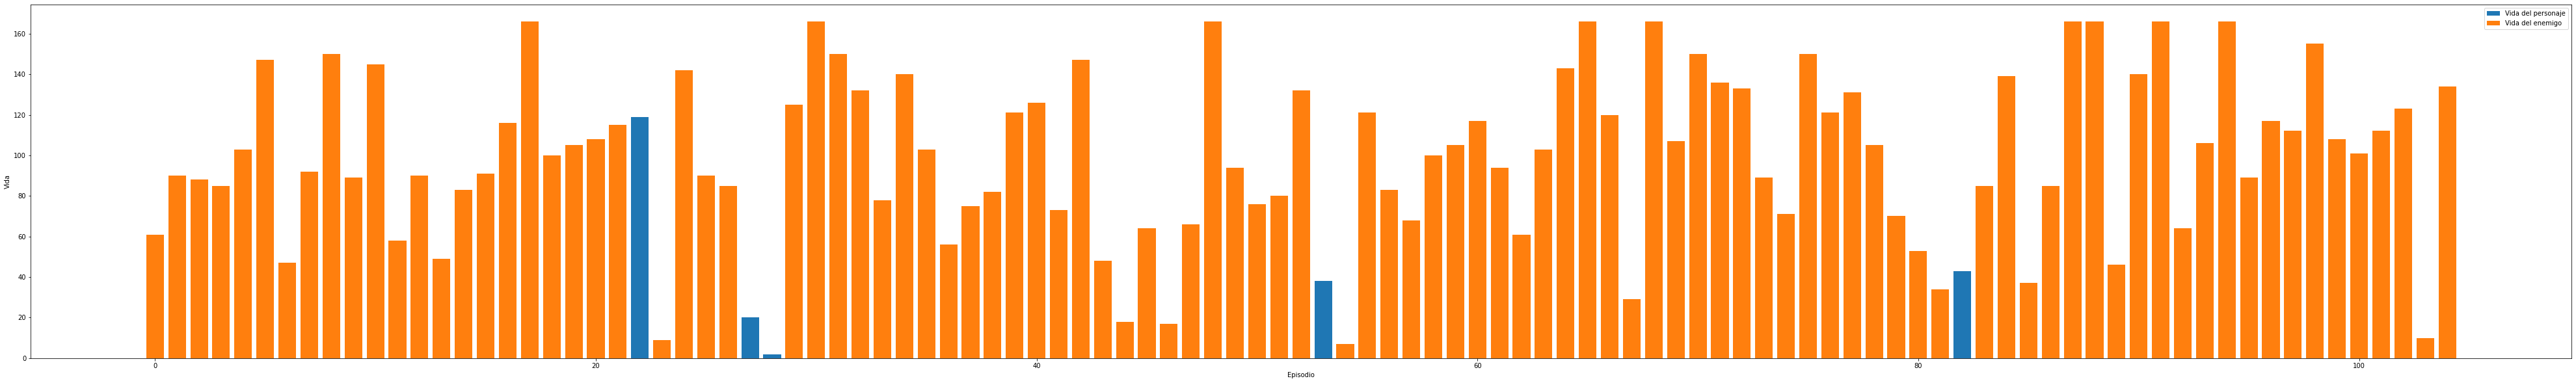

In [10]:
print("FRECUENCIA DE MÁXIMOS ENEMIGOS QUE DERROTÓ |||", {x:total_victorias.count(x) for x in total_victorias})
print("MEJOR RESULTADO ||| Enemigos derrotados:", mejor_victorias,
      "| Victorias contra últim@:", mejor_extras,
      "| Vida de últim@:", mejor_vida) #(No cuenta las iteraciones antes del primer ajuste de parámetros)
xs = np.linspace(1, 0, 166)
lineas = [0] + [(hist_episodios[i] != hist_episodios[i-1])*i for i in range(1, len(hist_episodios))]
lineas = [i for i in lineas if (i != 0)]
plt.figure(figsize=(70, 10))
plt.bar(range(len(hist_episodios)), hist_vida_personaje, label = "Vida del personaje")
plt.bar(range(len(hist_episodios)), hist_vida_enemigo, label = "Vida del enemigo")
plt.xlabel("Episodio")
plt.ylabel("Vida")
plt.legend(loc="upper right")
plt.show()

El mejor resultado no será recreable en la prueba con un modelo_base de 0. Esto es debido a que cuando es 0, la política de búsqueda hace que su comportamiento sea altamente aleatorio/irreproducible (con el fin de explorar una gran cantidad de combinaciones y luego poder perfeccionarlas).

##Prueba tras entrenar

In [11]:
#Aquí se genera el video de la simulación y se muestra la(s) acción(es) que toma el bot
#Cabe destacar que la batalla debe separarse en varios videos para no colapsar por falta de RAM
def main():
  frame = 0
  env = retro.make(game='MortalKombat3-Genesis')
  obs = env.reset()
  if (el_estado != ''):
    f = gzip.open(dir_estados+el_estado,'rb')
    file_content = f.read()
    f.close()
  else:
    file_content = ''
  env.em.set_state(file_content)
  dimensiones = obs.shape[:2]
  frames_a_ver = 20000
  accion_1 = [[1]*12]
  accion_2 = accion_1
  obs, rew, done, info = env.step(accion_1[0])
  obs_anterior = preprocesarImagen(obs)
  font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', 9)
  while (frames_a_ver >= 0):
    obs, obs_anterior, rew, done, info, accion_1, accion_2 = calculoDeUnaJugadaPrueba(env, obs, obs_anterior, accion_1, accion_2, 0)
    display.clear_output()
    im = Image.fromarray(obs[:,:,:])
    im = ImageOps.expand(im, border=16, fill=(255,255,255))
    draw = ImageDraw.Draw(im)
    draw.text((25,4),str(accion_1[0].numpy().tolist()),(0,0,0),font=font)
    im.save(str(frame) + '.png', )
    print(frame)
    print(info)
    if done: break
    frames_a_ver -= 1
    frame += 1
  print("Siguiente paso |", frame) #
  env.close()
  plt.clf()
  plt.close()
  n_frames_max = 1500
  for j in range(int(frame/n_frames_max)+1):
    frames = []
    for i in range(j*n_frames_max,min((j+1)*n_frames_max, frame)):
      frames.append(Image.open(str(i) +'.png'))
    max_fps = 60
    length = 30
    fps = np.clip(n_frames_max/length,max_fps,max_fps)
    p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', 'entrenado'+str(j)+'.mp4'], stdin=PIPE)
    for im in range(len(frames)):
      output.clear()
      print(str(im+1)+"/"+str(len(frames)), str(j)+"/"+str(int(frame/n_frames_max)+1))
      frames[im].save(p.stdin, 'PNG')
    p.stdin.close()
    p.wait()
  for j in range(int(frame/n_frames_max)+1):
    files.download('entrenado'+str(j)+'.mp4') 

if __name__ == "__main__":
  main()

683/683 1/2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>